In [1]:
%load_ext autoreload
%autoreload 2
from videoutils import *
import matplotlib.pyplot as plt

import math

import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision.transforms as T

torch.manual_seed(0)

Text(0.5, 1.0, 'First frame')

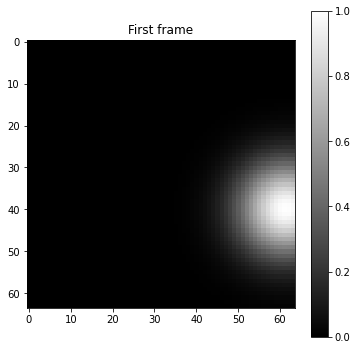

In [2]:
M = 64
N = 64
L = 8
n_frames = 300
amp = 20
n_periods = 10
noise_amp = 10
np.random.seed(0)
frames, X = simulate_moving_blob(M, N, L, n_frames, amp, n_periods, noise_amp)
#save_video("blob.avi", frames, 30)

frames = np.array(frames, dtype=float)/255
plt.figure(figsize=(6, 6))
plt.imshow(frames[:, :, 0, 0], cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title("First frame")

Text(0.5, 1.0, 'Y Coordinate')

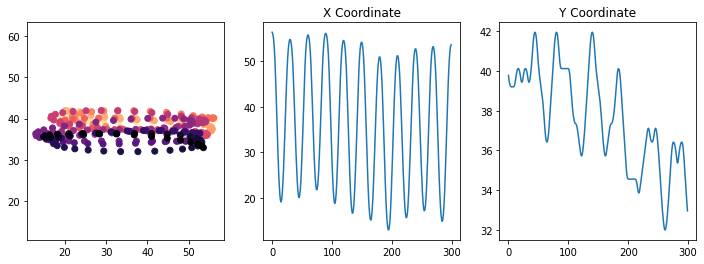

In [3]:
X = get_blob_cm(frames)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=np.arange(n_frames), cmap='magma_r')
plt.axis("equal")
plt.subplot(132)
plt.plot(X[:, 0])
plt.title("X Coordinate")
plt.subplot(133)
plt.plot(X[:, 1])
plt.title("Y Coordinate")

In [4]:
X = frames[:, :, 0, :]
X = np.moveaxis(X, [0, 1, 2], [1, 2, 0])
X = X[:, None, :, :]
print(X.shape)
print(np.min(X), np.max(X))

(300, 1, 64, 64)
0.0 0.996078431372549


cpu
0.19860,0.19817,0.19726,0.19666,0.19605,0.19541,0.19469,0.19386,0.19279,0.19134,0.18937,0.18671,0.18315,0.17848,0.17255,0.16530,0.15675,0.14694,0.13605,0.12425,0.11181,0.09919,0.08682,0.07513,0.06447,0.05544,0.04865,0.04408,0.04132,0.03987,0.03919,0.03885,0.03858,0.03824,0.03780,0.03728,0.03670,0.03605,0.03538,0.03472,0.03412,0.03360,0.03316,0.03280,0.03250,0.03224,0.03197,0.03172,0.03148,0.03123,0.03098,0.03074,0.03050,0.03026,0.03004,0.02984,0.02965,0.02948,0.02930,0.02912,0.02892,0.02872,0.02850,0.02826,0.02801,0.02772,0.02740,0.02707,0.02670,0.02629,0.02584,0.02535,0.02480,0.02419,0.02350,0.02273,0.02188,0.02100,0.02007,0.01912,0.01817,0.01725,0.01640,0.01562,0.01490,0.01426,0.01367,0.01314,0.01265,0.01219,0.01174,0.01133,0.01094,0.01057,0.01022,0.00991,0.00962,0.00936,0.00914,0.00893,0.00873,0.00856,0.00840,0.00826,0.00814,0.00802,0.00792,0.00782,0.00774,0.00766,0.00758,0.00752,0.00745,0.00739,0.00734,0.00728,0.00723,0.00719,0.00714,0.00709,0.00705,0.00700,0.00696,0.00691,0.00

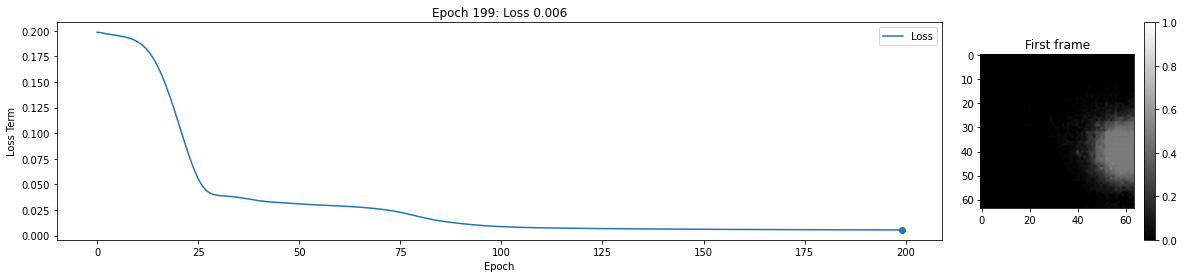

In [5]:
class AutoencoderCNN(nn.Module):
    def __init__(self, device, x, depth, dim,lr=1e-3):
        """
        Parameters
        ----------
        x: tensor(n_frames, 1, imgres, imgres)
            Original video
        depth: int
            Depth of the CNN
        dim: int
            Dimension of the latent space
        lr: float
            Learning rate
        """
        super(AutoencoderCNN, self).__init__()
        self.device = device
        self.x = x
        imgres = x.shape[-1]
        self.depth = depth
        self.dim = dim
        self.dim = dim
        
        ## Step 1: Create Convolutional Down Network
        self.convdown = nn.ModuleList()
        lastchannels = 1
        channels = 16
        for i in range(depth):
            self.convdown.append(nn.Conv2d(lastchannels, channels, 3, stride=2, padding=1))
            self.convdown.append(nn.ReLU())
            lastchannels = channels
            if i < depth-1:
                channels *= 2
        flatten = nn.Flatten()
        res_down = int(imgres/(2**depth))
        flatten_dim = channels*res_down**2
        latentdown = nn.Linear(flatten_dim, dim)
        latentdown_relu = nn.ReLU()
        self.convdown += [flatten, latentdown, latentdown_relu]
        
        ## Step 2: Create Convolutional up layer
        latentup = nn.Linear(dim, flatten_dim)
        latentup_relu = nn.ReLU()
        reshape = nn.Unflatten(1, (channels, res_down, res_down))
        self.convup = nn.ModuleList()
        self.convup += [latentup, latentup_relu, reshape]
        for i in range(depth):
            nextchannels = channels//2
            if i == depth-1:
                nextchannels = 1
            self.convup.append(nn.ConvTranspose2d(channels, nextchannels, 3, stride=2, padding=1, output_padding=1))
            channels = channels//2
            if i < depth-1:
                self.convup.append(nn.ReLU())
            else:
                self.convup.append(nn.Sigmoid())
        
        # Optimizer / Loss functions
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
    
    def forward(self):
        y = self.x
        for layer in self.convdown:
            y = layer(y)
        for layer in self.convup:
            y = layer(y)
        return y
    
    def train_step(self):
        self.optimizer.zero_grad()
        self.train()
        y = self.forward()
        loss = self.loss_fn(self.x, y)
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())
        return y, loss.item()

    def train_epochs(self, num_epochs):
        self.losses = []
        plot_idx = 0
        res = 4
        plt.figure(figsize=(res*5, res))
        y = None
        losses = []
        for epoch in range(num_epochs):
            y, loss = self.train_step()
            
            ## Everything below this point is just for plotting
            losses.append(loss)
            print("{:.5f}".format(loss), end=',')
            
            plt.clf()
            plt.subplot2grid((1, 5), (0, 0), colspan=4)
            plt.title("Epoch {}: Loss {:.3f}".format(epoch, loss))
            plt.plot(losses)
            plt.legend(["Loss"])
            plt.scatter([epoch], [loss], c='C0')
            plt.xlabel("Epoch")
            plt.ylabel("Loss Term")
            
            plt.subplot(155)
            I = y.cpu().detach().numpy()[0, 0, :, :]
            plt.imshow(I, cmap='gray', vmin=0, vmax=1)
            plt.colorbar()
            plt.title("First frame")
            
            
            plt.savefig("Iter{}.png".format(plot_idx), facecolor='white')
            plot_idx += 1
        return y



def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return 'cpu'#device

device = get_device()
print(device)
data = torch.from_numpy(X).float()
data = data.to(device)
autoencoder = AutoencoderCNN(device, data, depth=2, dim=100, lr=0.001)
autoencoder = autoencoder.to(device)

y = autoencoder.train_epochs(200)

In [6]:
res = y.cpu().detach().numpy()
res2 = np.moveaxis(res, (2, 3, 0, 1), (0, 1, 3, 2))
res2 = np.array(res2*255, dtype=np.uint8)
save_video("res.avi", res2, 30)

(64, 64, 3, 300)
